# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import os
import os.path as op
import shutil
import bokeh

# standard third party imports
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder

# impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import sys

In [46]:
import panel as pn
pn.extension('bokeh')

bokeh extension not recognized and will be skipped.


In [47]:
#standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning, initialize_environment,
    get_package_path, display_as_tabs, save_data, save_pipeline, load_dataframe, load_pipeline, load_dataset, DEFAULT_ARTIFACTS_PATH
)
import ta_lib.core.api as dataset
import ta_lib.eda.api as ta_analysis
from ta_lib.reports.api import create_report
import ta_lib.reports.api as health
from sklearn.ensemble import RandomForestClassifier
from ta_lib.classification.api import ClassificationComparison, ClassificationReport, confusion_matrix_by_feature, SKLStatsmodelLogit
from ta_lib.data_processing.api import Outlier, WoeBinningTransformer

from scripts import * 

os.environ['TA_DEBUG'] = "False"
os.environ['TA_ALLOW_EXCEPTIONS'] = "True"

# Initialization
initialize_environment(debug=False, hide_warnings=True)

In [48]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', message="bokeh extension not recognized and will be skipped.")
warnings.filterwarnings('ignore', message="The sklearn.metrics.classification module", category=FutureWarning)
warnings.filterwarnings('ignore', message=".*title_format is deprecated. Please use title instead.*")

In [49]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

# Initialization

In [50]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [51]:
display_as_tabs([('config', context.config)])

Tabs
    [0] JSON(dict, name='config')

# 3 EDA

Here we are doing a preliminary EDA on the dataset to add any features and findings

## 3.1 Read the Train and Test Data

In [52]:
train_X = load_dataset(context, 'train/merged/features')
train_y = load_dataset(context, 'train/merged/target')

test_X = load_dataset(context, 'test/merged/features')
test_y = load_dataset(context, 'test/merged/target')

num_columns = train_X.select_dtypes('number').columns

In [53]:
display_as_tabs([('train features old', train_X.shape), ('test features old', test_X.shape)])

Tabs
    [0] Str(tuple, name='train features old')
    [1] Str(tuple, name='test features old')

## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Inputation

### 3.2.2 Outlier Handling
- A functional Transformer is used to handle outliers. It is not included as part of the pipeline as outliers are handled only in the training data and not in test.
- An option to either drop or cap the outliers is presented in the drop key in the kw_args argument in the below example
- If we want to treat outliers for some columns them we can pass cols argument to the FunctionTransformer kw_args
- This will go into production code

In [54]:
outlier_transformer = Outlier(method='percentile')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)
train_y = train_y.loc[train_X.index]

(63016, 16)
(63016, 16)


### 3.2.3 Encoding and Missing Value Handling


#### Encoding

Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels. Not Feasible here as the decision variable is categorical(Binary)
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

Since the decision variable here is binary, onehot-encoding is choosed

Defining Columns Types

In [55]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns
display_as_tabs([('categorical columns', list(cat_columns)), ('numerical columns', list(num_columns))])

Tabs
    [0] JSON(list, name='categorical columns')
    [1] JSON(list, name='numerical columns')

#### Missing Value Handling

Obtaining the missing value summary of the features

In [56]:
missing_value_summary, missing_value_plot = ta_analysis.get_missing_values_summary(train_X.append(test_X), return_plot=True)
display_as_tabs([('data', missing_value_summary)])

Tabs
    [0] DataFrame(name='data', value=              ...)

## 3.2 Feature analysis

Using the pipeline above, analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

Sample of the data can be selected for testing out the pipeline.

### 3.2.2 Bivariate - mutual interactions

#### 3.2.2.1 Correlation based Elimination of Features

- Find columns with high correlations and drop them

Identifytion of Binary columns to ignore from the data for correlation plots

In [57]:
binary_num_columns = [x for x in train_X.columns if train_X[x].dropna().nunique()<=2]

In [58]:
corr_table = ta_analysis.get_correlation_table(train_X[list(set(train_X.columns).difference(set(binary_num_columns)))])
corr_table_drop = corr_table[corr_table["Abs Corr Coef"] > 0.6]
display_as_tabs([('combinations with > 0.6 correlation', corr_table_drop.head()),('number of combinations', len(corr_table_drop)), ('percentage of combinations', len(corr_table_drop)*100/len(corr_table))])

Tabs
    [0] DataFrame(name='combinations w..., value=              ...)
    [1] Str(int, name='number of combinations')
    [2] Str(float, name='percentage of c...)

There seem to be significant amount of combinations which are correlated.
So dropping columns that are highly correlated with eachother sequentially.

In [59]:
def columns_to_drop(corr_table, features_to_be_dropped=[], corr_threshold=0.6):
    """List the features to be dropped based on correlation coefficient threshold
    """
    corr_table = corr_table.sort_values('Variable 1')
    for index, row in corr_table.iterrows():
        if row['Abs Corr Coef'] > corr_threshold:
            if row['Variable 1'] not in features_to_be_dropped:
                features_to_be_dropped.append(row['Variable 2'])
    return(features_to_be_dropped)


columns_to_be_dropped = ['oppo_pro_tr_time_geo_id']
columns_to_be_dropped = columns_to_drop(corr_table, features_to_be_dropped=columns_to_be_dropped, corr_threshold=0.6)
corr_table_new = ta_analysis.get_correlation_table(train_X[list(set(train_X.columns).difference(set(binary_num_columns).union(columns_to_be_dropped)))])
corr_table_new_check = corr_table_new[corr_table_new["Abs Corr Coef"] > 0.6]
display_as_tabs([('combinations with > 0.6 correlation', corr_table_new_check.head()),('number of combinations', len(corr_table_new_check)), ('percentage of combinations', len(corr_table_new_check)*100/len(corr_table_new))])

Tabs
    [0] DataFrame(name='combinations w..., value=Empty DataFrame
Columns: [...)
    [1] Str(int, name='number of combinations')
    [2] Str(float, name='percentage of c...)

Finalising the curated columns that can be used in the modelling

In [60]:
curated_columns = list(set(train_X.columns) - set(columns_to_be_dropped))
curated_columns

['no_of_products',
 'geography',
 'core_sales_segment',
 'core_product_segment',
 'core_consumption_market',
 'progression_time_days',
 'opportunity_type',
 'decision_time_days',
 'core_product_application',
 'risk_status',
 'early_stages',
 'product_$',
 'product_status']

#### 3.2.2.2 Bivariate Plots
Individual plots for specific combinations fo variables can be obtained as follows

In [18]:
bivariate_plot = ta_analysis.get_bivariate_plots(train_X.merge(train_y, left_index=True, right_index=True), x_cols=curated_columns, y_cols=['target'])
display_as_tabs([('bivariate interaction scatter plot',bivariate_plot)])

Tabs
    [0] Row(name='bivariate interaction s...)
        [0] HoloViews(DynamicMap, name='bivariate interaction s...)
        [1] Column
            [0] WidgetBox
                [0] Select(margin=(20, 20, 20, 20), name='x_label', options=['opportunity_status (corr...], value='opportunity_status (..., width=250)
            [1] VSpacer()

For all combinations a bivariate plot report can be generated in the following way

In [19]:
health.feature_interactions(train_X[curated_columns],'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

Correlation with the target variable

In [61]:
target_corr = ta_analysis.get_target_correlation(df=train_X[set(curated_columns).difference(binary_num_columns)], y=train_y['target'])
display_as_tabs([(k, v) for k,v in target_corr.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')
    [1] HoloViews(Bars, name='mutual_information')

Feature Importances

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
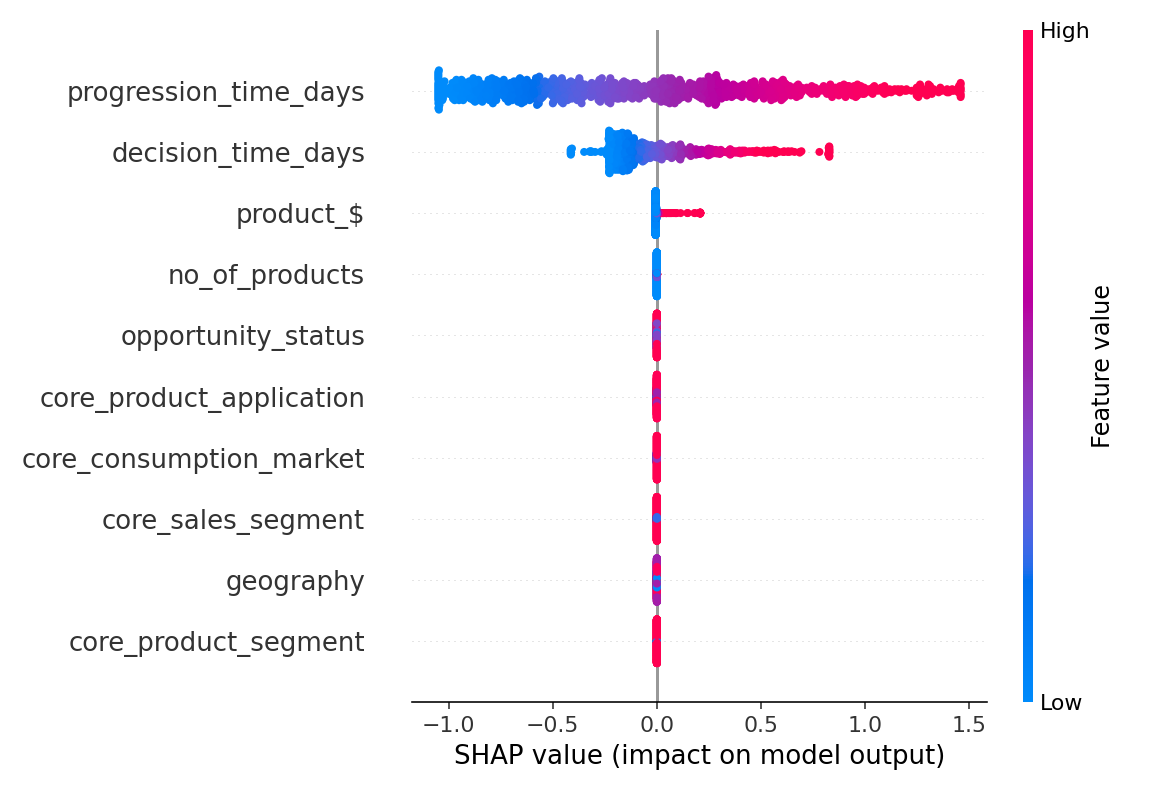

In [21]:
target_feat_imp = ta_analysis.get_feature_importances(train_X[set(curated_columns).difference(binary_num_columns)], train_y['target'])
display_as_tabs([(k, v) for k,v in target_feat_imp.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [22]:
health.key_drivers(train_X, train_y[['target']],'./key_drivers_report.html')

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1KvcVzYvhVgpe1rZiQY_en3ZeyCNY7fC5/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1hDwSooqSIZnAuVATZjfG78CfkJQqNBaM/view?usp=sharing)

In [23]:
health.data_exploration(train_X, train_y[['target']],'./data_exploration_report.html')

In [62]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# saving the list of relevant transformers/pipelines
# save_pipeline(feature_generation_ppln, op.abspath(op.join(artifacts_folder, 'feature_generation_ppln.joblib')))

save_pipeline(outlier_transformer, op.abspath(op.join(artifacts_folder, 'outlier_transformer.joblib')))

# save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features_transformer.joblib')))

# 4 Modelling

## 4.1 Modelling - Logistic Regression

### 4.1.1 Feature Selection(Specific to Logistic Regression)

- Selecting Features specific to logistic regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [63]:
cols_vif_analysis = curated_columns.copy()
vif = ta_analysis.calc_vif(train_X[cols_vif_analysis])
while vif.VIF.max() > 15:
    #removing the largest variable from VIF
    print(len(cols_vif_analysis))
    cols_vif_analysis.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = ta_analysis.calc_vif(train_X[cols_vif_analysis])
reg_vars = vif.variables.tolist()
reg_vars, len(reg_vars)

13
12
11
10
9
8
7


(['no_of_products',
  'progression_time_days',
  'decision_time_days',
  'core_product_application',
  'product_$',
  'product_status'],
 6)

Removing Columns with very less variance

In [64]:
variance_df = (train_X[reg_vars].var())
reg_vars=variance_df[variance_df>0.1].index.tolist()
reg_vars, len(reg_vars)

(['no_of_products',
  'progression_time_days',
  'decision_time_days',
  'product_$',
  'product_status'],
 5)

### 4.1.2 Data transformations

Custom Transformations like these can be utilised in case to select different set of features for different models

In [65]:
def custom_data_transform(df, cols2keep=[]):
    """Drop columns in the data.

    Parameters
    ----------
        df:  pd.DataFrame
            Dataframe in which requiredcolumns are to be kept
        cols2keep: list
            Columns to keep in the dataframe

    Returns
    -------
        df: pd.DataFrame
    """
    if len(cols2keep):
        return df.select_columns(cols2keep)
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [66]:
ppln_logit_stats = Pipeline([
    ('',FunctionTransformer(custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelLogit(method="l-bfgs-b"))
])
ppln_logit_stats.fit(train_X, train_y['target'])
ppln_logit_stats['estimator'].summary()

Optimization terminated successfully.
         Current function value: 0.255879
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                63016
Model:                          Logit   Df Residuals:                    63010
Method:                           MLE   Df Model:                            5
Date:                Tue, 01 Mar 2022   Pseudo R-squ.:                  0.4218
Time:                        16:23:25   Log-Likelihood:                -16124.
converged:                       True   LL-Null:                       -27889.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                -2.4865      0.054    -45.879      0.000      -2.593      -2.380
no_of_products            0.7756      0.021     37.822      0.000       0.735       0.816
progression_time_days     0.0009      0.000      4.522      0.000       0.001       0.001
decision_time_days       -0.0049      0.000    -31.945      0.000      -0.005      -0.005
product_$             -5.161e-10   2.98e-09     -0.173      0.862   -6.35e-09    5.32e-09
product_status            3.0574      0.033     92.661      0.000       2.993       3.122
=========================================================================================
"""

### 4.1.5 Model Evaluation(Logistic Model)

This will be part of the production code.

In [67]:
logit_ppln = Pipeline([
    ('', FunctionTransformer(custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelLogit(method="l-bfgs-b"))
])

cols_not_in_test = list(set(curated_columns) - set(test_X.columns))
cols_not_in_test_df = dict.fromkeys(cols_not_in_test, 0)
test_X = test_X.assign(**cols_not_in_test_df)
test_X = test_X[curated_columns]

reg_logit_report = ClassificationReport(model=logit_ppln, x_train=train_X, y_train=train_y['target'], x_test= test_X, y_test= test_y['target'], refit=True)

Optimization terminated successfully.
         Current function value: 0.255879
         Iterations 8


In [68]:
# reg_logit_report.get_report(include_shap=False, file_path='classification_logistic_model_report')

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/1KW-Nmy8HlG9eyUsUpSKBlcvw7hYGONKS/view?usp=sharing).
</details>

### 4.1.6 Classification error analysis

Here is a sample of error tuning for classification models. For more refer [here](https://tiger-analytic-code-templates.readthedocs-hosted.com/en/latest/code_templates/classification.html#understanding-error-patterns)

In [69]:
reg_logit_report.evaluator.get_confusion_matrix()

Nesting Layouts within a HoloMap makes it difficult to access your data or control how it appears; we recommend calling .collate() on the HoloMap in order to follow the recommended nesting structure shown in the Composing Data user guide (https://goo.gl/2YS8LJ)


:HoloMap   [decision_threshold]
   :Layout
      .Table.I  :Table   [#,Actual_0,Actual_1]
      .Table.II :Table   [#,Actual_0,Actual_1]

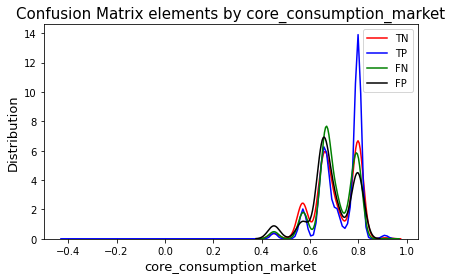

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [70]:
%matplotlib inline
x_eval = test_X.copy()
x_eval['prediction'] = (logit_ppln.predict_proba(x_eval)[:,1]>0.7).astype(int)
x_eval['actuals'] = test_y.reset_index().iloc[:,1].values.copy()
x_eval['prediction']=x_eval['prediction'].astype('int')
x_eval['actuals']=x_eval['actuals'].astype('int')
for col_ in ['core_consumption_market', 'product_id','geography']:
    confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv=col_,categorical=False)

In [ ]:
display_as_tabs((i,pd.DataFrame(reg_logit_report.gains_table()[i][0])) for i in ['train', 'test'])

In [71]:
perf_report = reg_logit_report.get_performance_report()

In [72]:
perf_report['metrics']

:HoloMap   [decision_threshold]
   :Table   [metric,test,train]

ROC Characteristics

In [73]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(x_eval['prediction'], x_eval['actuals'])
roc_auc = auc(fpr, tpr)

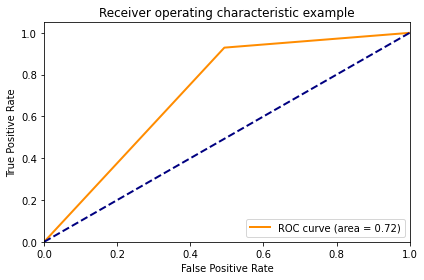

In [74]:
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()